# Project Instructions
The Head Data Scientist at Training Data Ltd. has asked you to create a DataFrame called `ds_jobs_transformed` that stores the data in `customer_train.csv` much more efficiently. Specifically, they have set the following requirements:
- Columns containing categories with only two factors must be stored as Booleans (bool).
- Columns containing integers only must be stored as 32-bit integers (int32).
- Columns containing floats must be stored as 16-bit floats (float16).
- Columns containing nominal categorical data must be stored as the category data type.
- Columns containing ordinal categorical data must be stored as ordered categories, and not mapped to numerical values, with an order that reflects the natural order of the column.
- The DataFrame should be filtered to only contain students with 10 or more years of experience at companies with at least 1000 employees, as their recruiter base is suited to more experienced professionals at enterprise companies.<br>
If you call `.info()` or `.memory_usage()` methods on `ds_jobs` and `ds_jobs_transformed` after you've preprocessed it, you should notice a substantial decrease in memory usage.

![Two data scientists working on a dashboard.](data/hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

You've been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

You've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so you can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

In [78]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load the dataset
ds_jobs = pd.read_csv("data/customer_train.csv")

# View the dataset
ds_jobs.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [79]:
# Create a copy of ds_jobs for transforming
ds_jobs_transformed = ds_jobs.copy()

In [80]:
ds_jobs_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevant_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  job_change              19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [81]:
# Set a professional plot style for a cleaner look.
sns.set_style("darkgrid")

The DataFrame should be filtered to only contain students with 10 or more years of experience at companies with at least 1000 employees, as their recruiter base is suited to more experienced professionals at enterprise companies.

In [82]:
# Convert experience to numeric values for filtering
# First, handle the special cases '<1' and '>20'
ds_jobs_transformed.loc[:, "experience_numeric"] = ds_jobs_transformed[
    "experience"
].replace({"<1": 0, ">20": 21})

# Convert to numeric
ds_jobs_transformed.loc[:, "experience_numeric"] = pd.to_numeric(
    ds_jobs_transformed["experience_numeric"], errors="coerce"
)

# Filter to keep only students with 10 or more years of experience
ds_jobs_transformed = ds_jobs_transformed[
    ds_jobs_transformed["experience_numeric"] >= 10
]

# Convert experience to int32 as required
ds_jobs_transformed.loc[:, "experience"] = ds_jobs_transformed[
    "experience_numeric"
].astype("int32")

# Drop the temporary column
ds_jobs_transformed = ds_jobs_transformed.drop("experience_numeric", axis=1)

#### Experience Distribution After Filtering

This line plot shows the distribution of years of experience among students after applying the 10+ years filter. The visualization confirms our filtering criteria and helps us understand the experience profile of our target demographic.

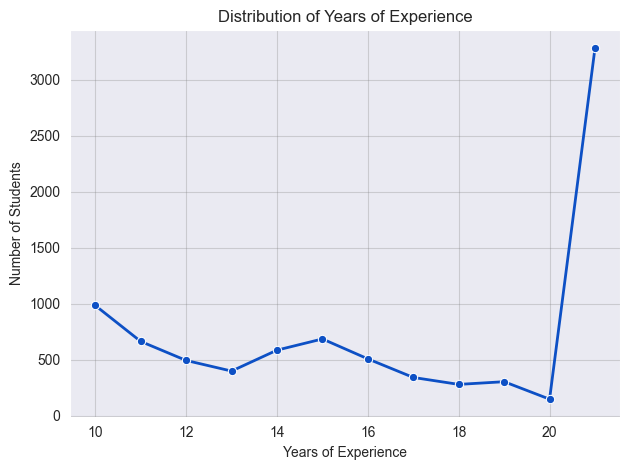

In [83]:
experience_counts = ds_jobs_transformed["experience"].value_counts().sort_index()

fig, ax = plt.subplots()

sns.lineplot(
    x=experience_counts.index,
    y=experience_counts.values,
    marker="o",
    linewidth=2,
    color="#0d50c5",
)

ax.set(
    xlabel="Years of Experience",
    ylabel="Number of Students",
    title="Distribution of Years of Experience",
)

ax.grid(True, alpha=0.3, color="gray", zorder=True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

The DataFrame should be filtered to only contain students with 10 or more years of experience at companies with at least 1000 employees, as their recruiter base is suited to more experienced professionals at enterprise companies.


In [84]:
# Convert company_size to numeric values for filtering
ds_jobs_transformed["company_size"] = ds_jobs_transformed["company_size"].replace(
    {
        "50-99": 100,
        "100-499": 500,
        "<10": 0,
        "500-999": 1000,
        "10000+": 10000,
        "5000-9999": 9999,
    }
)

# Convert to numeric
ds_jobs_transformed["company_size"] = pd.to_numeric(
    ds_jobs_transformed["company_size"], errors="coerce"
)

# Filter to keep only companies with at least 1000 employees
ds_jobs_transformed = ds_jobs_transformed[ds_jobs_transformed["company_size"] >= 1000]

# Convert company_size to int32 as required
ds_jobs_transformed["company_size"] = ds_jobs_transformed["company_size"].astype(
    "int32"
)

#### Company Size Distribution Analysis

The following plot shows the distribution of students across different company sizes after filtering for companies with at least 1000 employees. This visualization helps us understand the composition of our filtered dataset and ensures we're working with the target demographic of enterprise-level professionals.

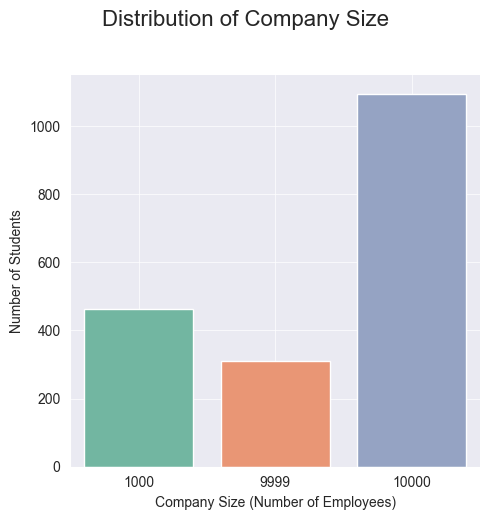

In [85]:
g = sns.catplot(
    x="company_size",
    data=ds_jobs_transformed,
    kind="count",
    palette="Set2",
    hue="company_size",
    legend=False,
)
g.figure.suptitle("Distribution of Company Size", fontsize=16, y=1.03)
g.set_axis_labels("Company Size (Number of Employees)", "Number of Students")

for ax in g.axes.flat:
    ax.grid(True, alpha=0.7)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### "student_id"

In [86]:
ds_jobs_transformed["student_id"] = ds_jobs_transformed["student_id"].astype("int32")

### "city"

In [87]:
# Convert city to category data type for memory efficiency
ds_jobs_transformed["city"] = ds_jobs_transformed["city"].astype("category")

# Note: City visualization is not practical due to the large number of unique city values

# The dataset contains too many distinct cities to create meaningful plots

# Any city-based visualization would be cluttered and difficult to interpret

# For analysis purposes, city data is better used for filtering or grouping operations

print(f"Number of unique cities: {ds_jobs_transformed['city'].nunique()}")
print(f"Total records: {len(ds_jobs_transformed)}")


Number of unique cities: 79
Total records: 1868


### "city_development_index"

In [88]:
ds_jobs_transformed["city_development_index"] = ds_jobs_transformed[
    "city_development_index"
].astype("float16")
ds_jobs_transformed["city_development_index"].value_counts()

city_development_index
0.919922    756
0.910156    185
0.624023    152
0.925781    149
0.938965     72
           ... 
0.646973      1
0.824219      1
0.518066      1
0.795898      1
0.839844      1
Name: count, Length: 62, dtype: int64

### "gender"

In [89]:
ds_jobs_transformed["gender"] = ds_jobs_transformed["gender"].astype("category")
ds_jobs_transformed["gender"] = np.where(
    ds_jobs_transformed["gender"].str.contains("Male", regex=False), True, False
)
ds_jobs_transformed["gender"] = ds_jobs_transformed["gender"].astype("bool")
ds_jobs_transformed["gender"].value_counts()

gender
True     1742
False     126
Name: count, dtype: int64

#### Gender Distribution Analysis by Relevant Experience

The following visualization examines how relevant work experience is distributed across genders in our filtered dataset. This analysis helps us understand the professional background composition and identify any potential patterns in experience levels between male and female students in enterprise-level companies.

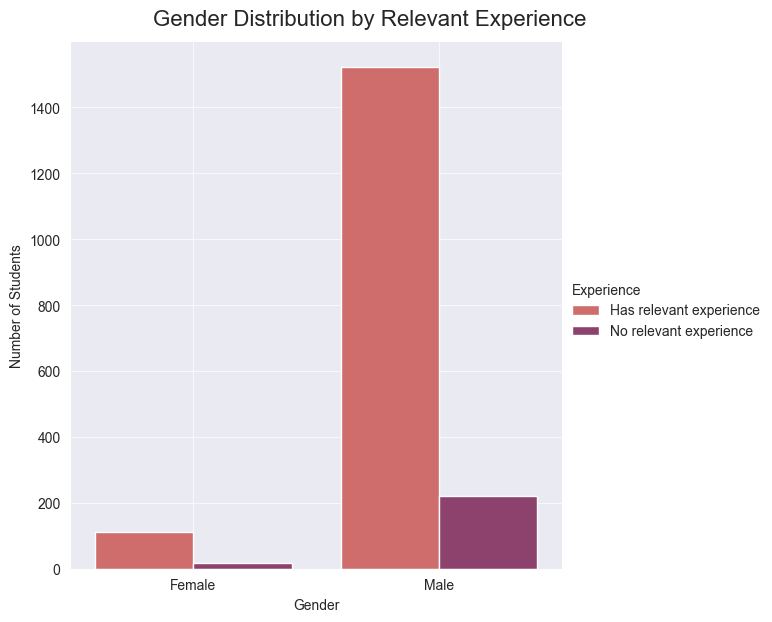

In [90]:
g = sns.catplot(
    x="gender",
    data=ds_jobs_transformed,
    kind="count",
    palette="flare",
    hue="relevant_experience",
    legend_out=True,
    height=6,
    aspect=1,
)

g.figure.suptitle("Gender Distribution by Relevant Experience", fontsize=16, y=1.03)
g.set_axis_labels("Gender", "Number of Students")

leg = g._legend
leg.set_title("Experience")
leg._legend_box.align = "left"

# Iterate through the axes to apply customizations.
for ax in g.axes.flat:
    ax.grid(True, alpha=0.7)
    ax.set_axisbelow(True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Female", "Male"])

plt.show()

### "relevant_experience"

In [91]:
ds_jobs_transformed["relevant_experience"] = ds_jobs_transformed["relevant_experience"].astype("category")
ds_jobs_transformed["relevant_experience"] = np.where(
    ds_jobs_transformed["relevant_experience"].str.contains("Has relevant experience", regex=False), True, False
)
ds_jobs_transformed["relevant_experience"] = ds_jobs_transformed["relevant_experience"].astype("bool")
ds_jobs_transformed["relevant_experience"].value_counts()

relevant_experience
True     1632
False     236
Name: count, dtype: int64

#### Relevant Experience vs University Enrollment Analysis

This visualization explores the relationship between students' relevant work experience and their current university enrollment status. Understanding this relationship helps identify patterns in continuing education among professionals with different experience backgrounds, which is valuable for targeted recruitment strategies.

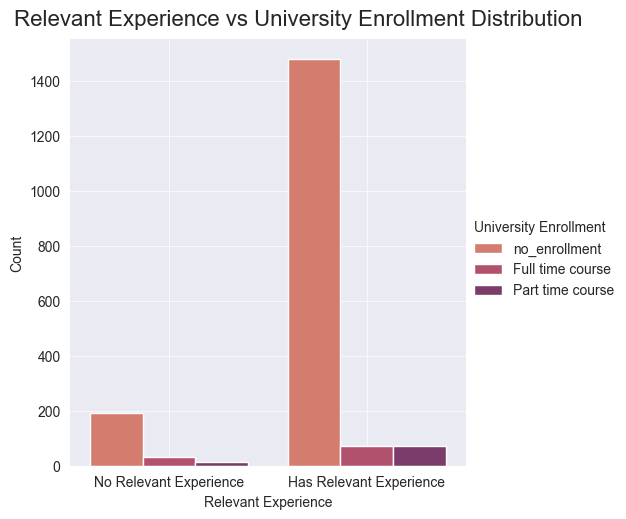

In [92]:
g = sns.catplot(
    x="relevant_experience",
    data=ds_jobs_transformed,
    kind="count",
    palette="flare",
    hue="enrolled_university",
    legend_out=True
)

g.figure.suptitle("Relevant Experience vs University Enrollment Distribution", fontsize=16, y=1.03)
g.set_axis_labels("Relevant Experience", "Count")

leg = g._legend
leg.set_title("University Enrollment")
leg._legend_box.align = "left"

for ax in g.axes.flat:
    ax.grid(True, alpha=0.7)
    ax.set_axisbelow(True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Relevant Experience', 'Has Relevant Experience'])

sns.despine(left=True)
plt.show()

In [93]:
ds_jobs_transformed["enrolled_university"] = ds_jobs_transformed[
    "enrolled_university"
].astype("category")

ds_jobs_transformed["enrolled_university"] = ds_jobs_transformed[
    "enrolled_university"
].cat.reorder_categories(
    new_categories=["no_enrollment", "Part time course", "Full time course"],
    ordered=True,
)
ds_jobs_transformed["enrolled_university"].value_counts(sort=False)

enrolled_university
no_enrollment       1668
Part time course      87
Full time course     103
Name: count, dtype: int64

#### University Enrollment Distribution by Relevant Experience

This plot provides another perspective on the relationship between university enrollment and relevant experience. It helps us understand how students with different experience levels engage in continuing education, which is crucial for recruitment targeting.

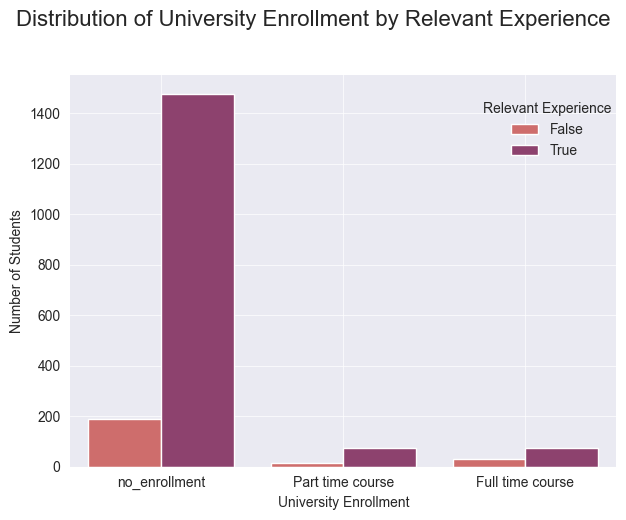

In [94]:
g = sns.catplot(
    x="enrolled_university",
    data=ds_jobs_transformed,
    kind="count",
    palette="flare",
    hue="relevant_experience",
    
)

g.figure.suptitle("Distribution of University Enrollment by Relevant Experience", fontsize=16, y=1.03)
g.set_axis_labels("University Enrollment", "Number of Students")

leg = g._legend
leg.set_title("Relevant Experience")
leg.set_bbox_to_anchor((0.98,.78))

for ax in g.axes.flat:
    ax.grid(True, alpha=0.7)
    ax.set_axisbelow(True)

sns.despine(left=True)
plt.tight_layout()
plt.show()

### "education_level"

In [95]:
ds_jobs_transformed["education_level"] = ds_jobs_transformed["education_level"].astype(
    "category"
)

ds_jobs_transformed["education_level"] = ds_jobs_transformed[
    "education_level"
].cat.reorder_categories(
    new_categories=["Primary School", "High School", "Graduate", "Masters", "Phd"],
    ordered=True,
)
ds_jobs_transformed["education_level"].value_counts(sort=False)

education_level
Primary School       4
High School         61
Graduate          1083
Masters            610
Phd                 96
Name: count, dtype: int64

#### Education Level Distribution by Gender

This visualization examines the distribution of education levels across genders in our filtered dataset. Understanding educational backgrounds helps identify qualification patterns and potential recruitment opportunities across different demographic segments.

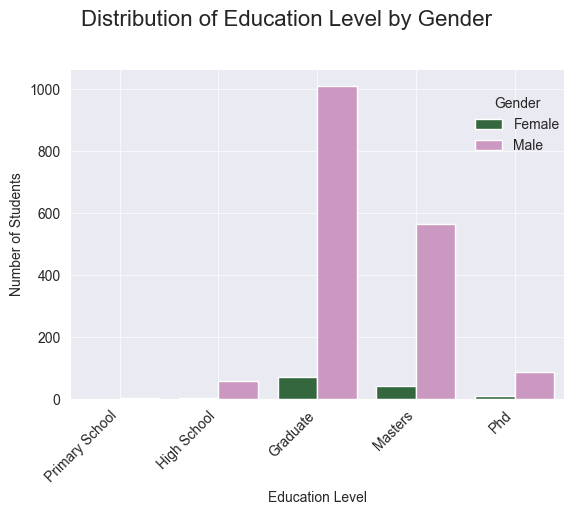

In [96]:
# Filter out rows with missing education_level data
plot_data = ds_jobs_transformed.dropna(subset=["education_level"])

g = sns.catplot(
    x="education_level",
    data=plot_data,
    kind="count",
    palette="cubehelix",
    hue="gender",
    legend_out=True,
)

g.figure.suptitle("Distribution of Education Level by Gender", fontsize=16, y=1.02)
g.set_axis_labels("Education Level", "Number of Students")

# Check if legend exists before accessing it
if g._legend is not None:
    leg = g._legend
    leg.set_title("Gender")
    leg.set_bbox_to_anchor((0.98, 0.78))

    # Update legend labels to show actual gender names
    for text, label in zip(leg.get_texts(), ["Female", "Male"]):
        text.set_text(label)

for ax in g.axes.flat:
    ax.grid(True, alpha=0.7)
    ax.set_axisbelow(True)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

plt.tight_layout()
plt.show()

### "major_discipline"

In [97]:
ds_jobs_transformed["major_discipline"] = ds_jobs_transformed["major_discipline"].astype("category")
ds_jobs_transformed["major_discipline"].value_counts(sort=False)

major_discipline
Arts                 24
Business Degree      38
Humanities           59
No Major             19
Other                32
STEM               1615
Name: count, dtype: int64

#### Major Discipline Distribution by Gender

This plot shows the distribution of academic disciplines across genders, revealing field preferences and representation patterns. This information is valuable for understanding the educational diversity of our target population and tailoring recruitment strategies by discipline.

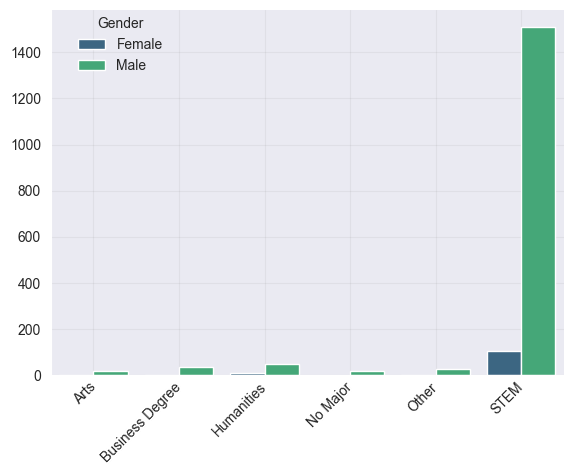

In [98]:
g = sns.catplot(
    x="major_discipline",
    data=ds_jobs_transformed,
    kind="count",
    palette="viridis",
    hue="gender",
    legend_out=True
)

g.figure.suptitle("")
g.set_axis_labels("", "")

leg = g._legend
leg.set_title("Gender")
leg.set_bbox_to_anchor((0.3, 0.86))

for text, label in zip(leg.get_texts(), ["Female", "Male"]):
    text.set_text(label)


for ax in g.axes.flat:
    ax.grid(True, alpha=0.1, color="gray")
    ax.set_axisbelow(True)
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        va="center",
        rotation_mode="anchor",
    )

plt.tight_layout()
plt.show()

### "company_type"

In [99]:
ds_jobs_transformed["company_type"] = ds_jobs_transformed["company_type"].astype("category")

#### Company Type Distribution by Company Size

This comprehensive visualization shows how different company types are represented across various company sizes in our filtered dataset. Understanding the corporate landscape helps identify the most common employer profiles and informs recruitment strategy development.

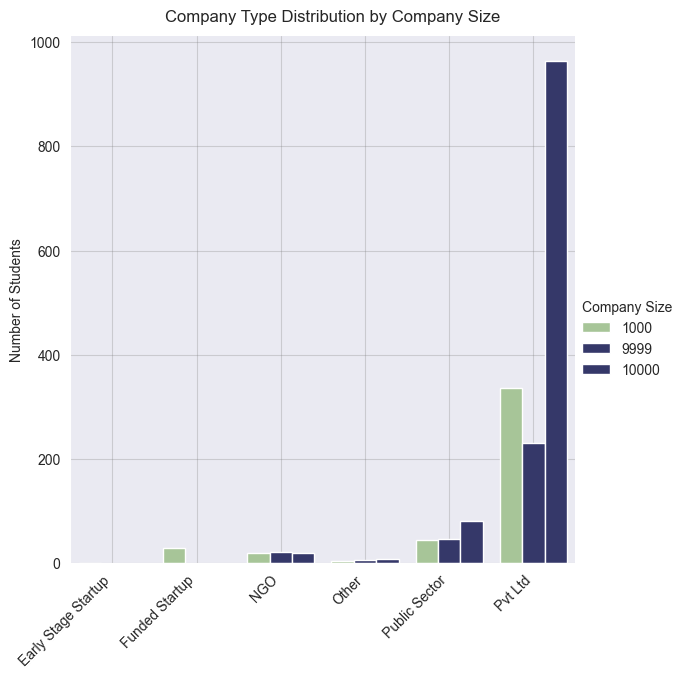

In [100]:
g = sns.catplot(
    x="company_type",
    data=ds_jobs_transformed,
    kind="count",
    hue="company_size",
    palette="crest",
    legend_out=True,       
    height=6,              
    aspect=1               
)

g.figure.suptitle("Company Type Distribution by Company Size", y=1.02)
g.set_axis_labels("", "Number of Students")

# Rotate x‐labels and add grid
for ax in g.axes.flat:
    ax.grid(True, color="gray", alpha=0.3)
    ax.set_axisbelow(True)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

leg = g._legend
leg.set_title("Company Size")
leg._legend_box.align = "left"

plt.show()

In [101]:
ds_jobs_transformed["last_new_job"].value_counts(dropna=False)

last_new_job
>4       691
1        506
2        303
4        151
3        140
never     64
NaN       13
Name: count, dtype: int64

In [102]:
# Convert last_new_job to numeric values
ds_jobs_transformed["last_new_job"] = ds_jobs_transformed["last_new_job"].replace(
    {">4": 5, "never": 0}
)

# Convert to numeric and handle NaN values
ds_jobs_transformed["last_new_job"] = (
    pd.to_numeric(ds_jobs_transformed["last_new_job"], errors="coerce")
    .fillna(0)
    .astype("int32")
)

In [103]:
ds_jobs_transformed["last_new_job"].value_counts(dropna=False)

last_new_job
5    691
1    506
2    303
4    151
3    140
0     77
Name: count, dtype: int64

#### Years Since Last Job Change Distribution

This line plot illustrates the distribution of time since students' last job change. Understanding job mobility patterns helps identify career transition trends and timing, which is essential for effective job placement and recruitment timing strategies.

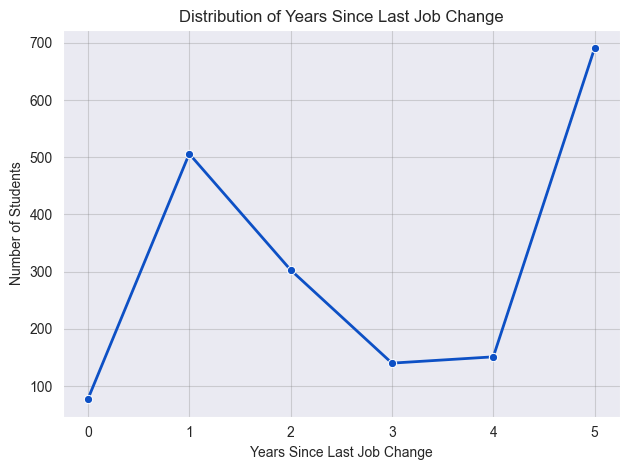

In [104]:
lastnew_counts = ds_jobs_transformed["last_new_job"].value_counts().sort_index()

fig, ax = plt.subplots()

sns.lineplot(
    x=lastnew_counts.index,
    y=lastnew_counts.values,
    marker="o",
    linewidth=2,
    color="#0d50c5",
)

ax.set(
    xlabel="Years Since Last Job Change",
    ylabel="Number of Students",
    title="Distribution of Years Since Last Job Change",
)

ax.grid(True, alpha=0.3, color="gray", zorder=True)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [105]:
ds_jobs_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1868 entries, 9 to 19143
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   student_id              1868 non-null   int32   
 1   city                    1868 non-null   category
 2   city_development_index  1868 non-null   float16 
 3   gender                  1868 non-null   bool    
 4   relevant_experience     1868 non-null   bool    
 5   enrolled_university     1858 non-null   category
 6   education_level         1854 non-null   category
 7   major_discipline        1787 non-null   category
 8   experience              1868 non-null   object  
 9   company_size            1868 non-null   int32   
 10  company_type            1807 non-null   category
 11  last_new_job            1868 non-null   int32   
 12  training_hours          1868 non-null   int64   
 13  job_change              1868 non-null   float64 
dtypes: bool(2), category(5), flo

The `"experience"` column repeatedly reverts to the `"object"` dtype. To address this, I have decided to convert it to the `"int32"` dtype once more before finalizing the project. This will help ensure the dataset remains efficient and optimizes memory usage.


In [106]:
ds_jobs_transformed["experience"] = ds_jobs_transformed["experience"].astype("int32")

### "training_hours"

In [107]:
ds_jobs_transformed["training_hours"] = ds_jobs_transformed["training_hours"].astype("int32")
ds_jobs_transformed["training_hours"].value_counts()

training_hours
18     33
26     32
28     32
22     31
20     30
       ..
198     1
268     1
139     1
246     1
150     1
Name: count, Length: 213, dtype: int64

### "job_change"

In [108]:
ds_jobs_transformed["job_change"].value_counts()

job_change
0.0    1616
1.0     252
Name: count, dtype: int64

In [109]:
ds_jobs_transformed["job_change"] = (ds_jobs_transformed["job_change"] == 1.0).astype("bool")
ds_jobs_transformed["job_change"].value_counts()


job_change
False    1616
True      252
Name: count, dtype: int64

In [110]:
ds_jobs_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1868 entries, 9 to 19143
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   student_id              1868 non-null   int32   
 1   city                    1868 non-null   category
 2   city_development_index  1868 non-null   float16 
 3   gender                  1868 non-null   bool    
 4   relevant_experience     1868 non-null   bool    
 5   enrolled_university     1858 non-null   category
 6   education_level         1854 non-null   category
 7   major_discipline        1787 non-null   category
 8   experience              1868 non-null   int32   
 9   company_size            1868 non-null   int32   
 10  company_type            1807 non-null   category
 11  last_new_job            1868 non-null   int32   
 12  training_hours          1868 non-null   int32   
 13  job_change              1868 non-null   bool    
dtypes: bool(3), category(5), flo

### Project Conclusion

In this project, the objective was to transform the `customer_train.csv` dataset into a more efficient and focused format for future modeling tasks. The primary rationale was that large datasets can be computationally expensive to work with, and optimizing them is a critical first step in any data science workflow.

My approach was twofold: first, to reduce the memory footprint of the DataFrame, and second, to filter the data to align with the specific business requirement of targeting experienced professionals at enterprise-level companies.


1.  **Data Type Optimization:** I analyzed each column to assign the most memory-efficient data type.
    *   Binary categorical columns like `gender` and `relevant_experience` were converted to the `bool` type.
  <br>
    *   Numerical columns were downcast; for example, I used `int32` for integers and `float16` for floating-point numbers where appropriate, which significantly reduced memory without sacrificing necessary precision.
  <br>
    *   Nominal and ordinal categorical columns (`enrolled_university`, `education_level`, etc.) were converted to pandas' `category` dtype. For ordinal columns, I explicitly defined the order to preserve their inherent hierarchy, which is crucial for certain modeling techniques.

1.  **Strategic Filtering:** To meet the project's requirements, I filtered the dataset to include only students with 10 or more years of experience working at companies with 1000 or more employees. This involved cleaning and converting columns like `experience` and `company_size` from object types to numerical formats that could be used for comparison.

2.  **Documented Exploration:** Throughout the process, I used visualizations to explore and validate the transformations. I made some decisions to add markdown cells before each plot to document my thought process and explain what the visualization revealed about the data. This practice makes the notebook a self-contained and easily understandable piece of analysis.

The final `ds_jobs_transformed` DataFrame is substantially more memory-efficient than the original, which will accelerate subsequent modeling and analysis. By focusing the dataset on the target demographic, we ensure that any insights or predictive models generated will be directly relevant to the business goal. 